# 2D Percolation Simulation

## The drawing table

First of all we have to create a grid of size L. With a $p$ probability that each of the squares inside the raster is occupied.
We will do this by creating a matrix where all the elements are initially zero and have a chance $p$ to be 1.

In [1]:
import numpy as np
import random
import time
from scipy.optimize import curve_fit
import collections

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
from numba import jit

In [4]:
#this function will give True or False to later determine what elements will be coloured in the grid.
@jit(nopython=True)
def decision(probability):
    return random.random() < probability

In [5]:
@jit(nopython=True)
def one_or_zero(probability):
    if decision(probability):
        return 1
    else:
        return 0

In [6]:
@jit(nopython=True)
def create_world(size,probability):
    field= np.zeros(size**2)  #create vector to make the iteration easier
    for i in range(size**2):
        field[i]=one_or_zero(probability)     #make certain elements one and zero depending on the prob
    return field

In [7]:
%%time
M=create_world(5,0.5)
M

Wall time: 358 ms


array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 1.])

In [8]:
from matplotlib import pyplot as plt
from matplotlib import colors

def draw_array(array):
    size=int(np.sqrt(len(array)))
    M=np.reshape(array,(size,size))
    cmap = colors.ListedColormap(['White','Red'])
    plt.figure(figsize=(5,5))
    plt.pcolor(M[::-1],cmap=cmap,edgecolors='k', linewidths=0.1)
    plt.show()

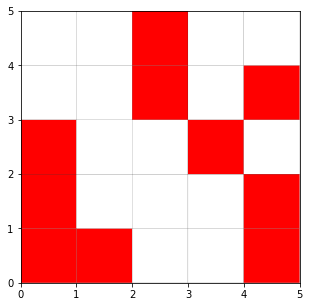

In [9]:
draw_array(M)

## How to count?

We will now implement an algoritm to count the amount of clusters in the grid. The method I have chosen is the Hoshen and Kopelman algortim.

The function below returns the number of clusters, the list in where the clusters are counted with their respective number of sites (negative means that this one is 'slorped' by another cluster), the matrix in which the different numbers can be shown,  the number of unoccupied sites and the number of the sites in the largest cluster.

In [10]:
@jit(nopython=True)
def occupied(el):
    return el==1

In the method we have to keep up with the track of how the cluster size of a cluster. We do this by making a list. Which after several iterations look like this as an example:

In [11]:
np.array([3.,0.,3.,2.,1.])

array([3., 0., 3., 2., 1.])

Because of how indexing works in Python. In the above array we have that the amount of zeros is equal to 3. The amount of cluster 2 is 3, cluster 3 is 2 etc...

However, when two clusters meet, for example cluster 2 and 3 we merge the two clusters to the cluster of the upper one. The cluster size of 3 is transferred to cluster 2 and cluster two will be pointed to cluster 2.
And the list should look the following:

In [12]:
y=np.array([3.,0.,5.,-2.,1.])

And then when we get a new occupied space that is related to cluster 3, the new zone should be counted for for the 'true label' of cluster 3, which is cluster 2.
The following function helps us with that:

In [13]:
@jit(nopython=True)
def get_true_label(value,lijst):
    true_value=value
    if lijst[int(value)]>0:
        true_value = true_value
    else:
        true_value=get_true_label(-lijst[int(value)], lijst)
        lijst[int(value)]=-true_value
    return true_value

In [14]:
get_true_label(3,y)

2.0

In [15]:
Y=np.array([3.,0.,5.,-2.,-3.])

When the upper cluster $\textit{already}$ is pointed to another cluster we still et the true label:

In [16]:
get_true_label(4,Y)

2.0

In [17]:
Y

array([ 3.,  0.,  5., -2., -2.])

The next function works the same way but instead it returns the value, it returns the cluster size of the 'true label'- cluster. This is needed when the cluster is being assigned, is already pointed to another cluster. 

In [18]:
@jit(nopython=True)
def get_true_label_value(value,lijst):
    if lijst[int(value)]>0:
        return lijst[int(value)]
    else:
        return get_true_label_value(-lijst[int(value)], lijst)

In [19]:
x=np.array([3.,0.,5.,-2.,-2.])
get_true_label_value(4,x)

5.0

Next function counts one for the true cluster if nothing is being merged or anything.

In [20]:
@jit(nopython=True)
def count_true_cluster(cell,lijst):
    label=get_true_label(cell,lijst)
    lijst[int(label)]+=1

This is a smaal workaround because the package numba does not work well with deleting items from a list.

In [21]:
@jit(nopython=True)
def delete_workaround(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]

Now we have everything for the algoritm.

In [22]:
@jit(nopython=True)
def Hoshen_and_Kopelman(array):
    U=np.copy(array)
    L=int(np.sqrt(len(array)))
    
    l=2
    lijst =np.zeros(round(len(array)/2))

    
    if occupied(U[0]):  #first element
        U[0]=l
        lijst[l]+=1
        l+=1
    else:
        lijst[0]+=1
        
    for i in range(L-1): #top row
        i+=1
        if occupied(U[i]):
            if U[i-1]!=0:         #look left
                U[i]=U[i-1]
                lijst[int(U[i-1])]+=1.
            else:
                U[i]=l
                lijst[l]+=1
                l+=1
        else:
            lijst[0]+=1
            
    for i in range((L**2-L)):
        i+=L                        #skip the first row
        if i % L == 0:              #first column does not have to look left
            if occupied(U[i]):
                if U[i-L]!=0:           #look up
                    U[i]=U[i-L]
                    count_true_cluster(U[i],lijst)
                else:
                    U[i]=l
                    lijst[l]+=1
                    l+=1
            else:
                lijst[0]+=1


        elif occupied(U[i]):
            if U[(i-L)]!=0:            #look up
                U[i]=U[i-L]
                count_true_cluster(U[i],lijst)

                if U[i-1]!=0:             #look left AND up to merge
                    if get_true_label(U[i],lijst)!=get_true_label(U[i-1],lijst):  #if both elements are from the same cluster, mer

                               #below is the tricky part, we have to add the true label size! of left to cluster of the current one (=cluster of top one)
                            lijst[int(get_true_label(U[i],lijst))]+=(get_true_label_value(U[i-1], lijst)) 
                            lijst[int(get_true_label(U[i-1],lijst))]=-U[i] #and now the true label of left becomes the current one

            elif U[i-1]!=0:         #look left
                U[i]=U[i-1]
                count_true_cluster(U[i],lijst)

            else:
                U[i]=l
                lijst[l]+=1
                l+=1
        else:
            lijst[0]+=1
          
    cluster_sizes_without_largest_one= np.array([i  for i in lijst[1:] if i>0])
    cluster_sizes= np.copy(cluster_sizes_without_largest_one) 
    
    number_of_clusters= len(cluster_sizes)
    
    largest_cluster=np.max(lijst[1:])
    
    cluster_sizes_without_largest_one=delete_workaround(cluster_sizes,largest_cluster)
    
    
    if number_of_clusters != 0:
        average_cluster_sizes_without_largest_one= np.sum(np.power(cluster_sizes_without_largest_one,2)) / (number_of_clusters)
    else:
        average_cluster_sizes_without_largest_one=0
    
    fraction = largest_cluster/(L**2)
    
    return number_of_clusters, lijst, largest_cluster, fraction, cluster_sizes, cluster_sizes_without_largest_one, average_cluster_sizes_without_largest_one

In [24]:
%%time
M=create_world(1000,0.9)
result=Hoshen_and_Kopelman(M)

Wall time: 114 ms


## Example

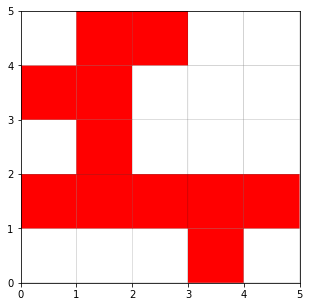

In [25]:
M=create_world(5,0.5)
small_world=Hoshen_and_Kopelman(M)
draw_array(M)

Number of clusters:

In [26]:
small_world[0]

1

Largest cluster size:

In [27]:
small_world[2]

11.0

# Order Parameters

In [28]:
def func(x, a, b):
    return a*(x)**b

In [38]:
var_p=np.linspace(0.0001,0.5,5)
var_p=np.append(var_p,np.linspace(0.55,0.65,num=50))
var_p=np.append(var_p,np.linspace(0.66,1,num=10))
# var_p=np.linspace(0.01,0.99,15)

In [39]:
@jit(nopython=True)

def perculation(x,size):
    occupation_fraction=np.zeros(len(x))
    average_cluster_size=np.zeros(len(x))
    for i in range(len(x)):
        U=create_world(size,x[i])
        HK=Hoshen_and_Kopelman(U)
        occupation_fraction[i]=HK[3]
        average_cluster_size[i]=HK[6]
    return occupation_fraction, average_cluster_size

In [40]:
@jit(nopython=True)
def average(x,size, iterations):
    count_occupation=np.zeros(len(x))
    average_cluster_size=np.zeros(len(x))
    for it in range(iterations):
        a=perculation(x,size)
        count_occupation+=a[0]
        average_cluster_size+=a[1]
    return count_occupation/iterations, average_cluster_size/iterations

In [98]:
%%time
# occupation =average(var_p,5000, 5)
# occupation2000=average(var_p,2000, 10)
occupation1000=average(var_p,1000, 50)

Wall time: 3min 18s


## $P_c$

In [99]:
Pinf=occupation[0]

In [100]:
id=next(x[0] for x in enumerate(occupation[0]) if x[1] > 0.1)
Pc=var_p[id]
Pc

0.5928571428571429

The percolation threshold we found is 0.0.59286. This comes very close to more exact value of 0.0.59274 (source:https://en.wikipedia.org/wiki/Percolation_threshold#Inhomogeneous_2-uniform_lattice)

In [101]:
Pc=np.float(0.5927461)
id=next(x[0] for x in enumerate(var_p) if x[1] > Pc)

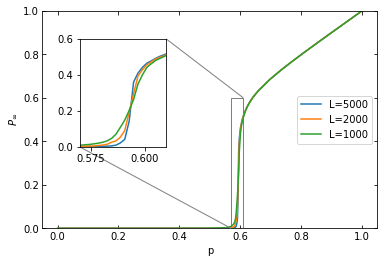

In [103]:
fig, ax = plt.subplots() # create a new figure with a default 111 subplot
plt.xlabel('p')
plt.ylabel('$P_{\infty}$')
plt.ylim([0, 1])
ax.plot(var_p,Pinf,label='L=5000')
ax.plot(var_p,occupation2000[0],label='L=2000')
ax.plot(var_p,occupation1000[0],label='L=1000')
plt.legend(loc='center right')
ax.tick_params(axis="both", direction="in", top=True, right=True)

# axins = zoomed_inset_axes(ax, 4, loc=2)
axins =inset_axes(ax, 1.2,1.5 , loc=2,bbox_to_anchor=(0.2, 0.8),bbox_transform=ax.figure.transFigure)
axins.plot(var_p,Pinf)
axins.plot(var_p,occupation2000[0])
axins.plot(var_p,occupation1000[0])
x1, x2, y1, y2 = 0.57, 0.61, 0,0.6 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")


plt.show()

# $\beta$

In [110]:
%%time
v=np.logspace(-5.0, 0, num=50)+Pc
var_exp_pos=np.array([el for el in v if Pc<(el)<1])

occupation_exp_pos =average(var_exp_pos,5000, 5)

Wall time: 6min 20s


In [111]:
Pinf_exp_pos=occupation_exp_pos[0]

In [115]:
var_beta=var_exp_pos
Pinf_beta=Pinf_exp_pos

var_beta_2=var_exp_pos[-15:-7]#var_beta[5:-22]
Pinf_beta_2=Pinf_exp_pos[-15:-7]#Pinf_beta[5:-22]

In [116]:
popt, pcov = curve_fit(func, (var_beta_2- Pc),Pinf_beta_2)
popt

array([0.95148044, 0.15085731])

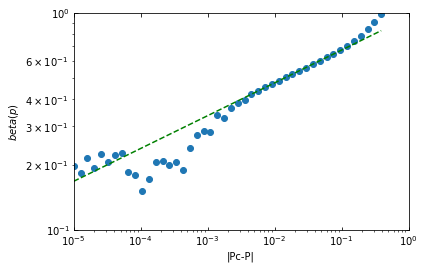

beta = 0.15085731465625066


In [117]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.scatter(var_beta- Pc,Pinf_beta)
plt.plot((var_beta- Pc), func(var_beta- Pc, *popt), '--', color='green')

plt.xscale('log')
plt.yscale('log')

plt.xlim(10**(-5), 1)
plt.ylim(0.1, 1)
plt.xlabel('|Pc-P|')
plt.ylabel('$beta(p)$')
plt.show()
print('beta =', popt[1])

In [123]:
5/36

0.1388888888888889

## Average Cluster Size

In [118]:
acs=occupation[1]

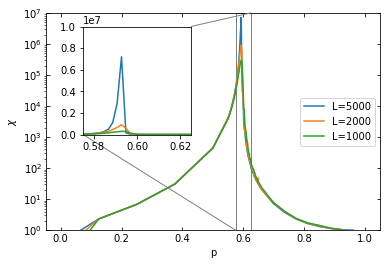

In [139]:
fig, ax = plt.subplots() # create a new figure with a default 111 subplot
plt.xlabel('p')
plt.ylabel('$\chi$')
# plt.ylim([0, 1])
ax.plot(var_p,acs,label='L=5000')
ax.plot(var_p,occupation2000[1],label='L=2000')
ax.plot(var_p,occupation1000[1],label='L=1000')
plt.legend(loc='center right')

plt.ylim(1,10**7)
plt.yscale('log')

ax.tick_params(axis="both", direction="in", top=True, right=True)

axins =inset_axes(ax, 1.5,1.5 , loc=2,bbox_to_anchor=(0.2, 0.85),bbox_transform=ax.figure.transFigure)

axins.plot(var_p,acs)
axins.plot(var_p,occupation2000[1])
axins.plot(var_p,occupation1000[1])
x1, x2, y1, y2 = 0.575, 0.625,1, 10**7 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
# axins.set_yscale('log')
# plt.yticks(visible=False)
# plt.xticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")


plt.show()

## $\gamma$

In [128]:
%%time
v=Pc-np.logspace(-5.0, 0, num=50)
var_exp_neg=np.array([el for el in v if 0<(el)<Pc])

occupation_exp_neg =average(var_exp_neg,5000, 3)

Wall time: 3min 37s


In [140]:
acs_gamma_pos=occupation_exp_pos[1]
acs_gamma_neg=occupation_exp_neg[1]

In [141]:
#positive
var_gamma_pos=var_exp_pos
acs_gamma_pos=acs_gamma_pos

#negative
var_gamma_neg=var_exp_neg
acs_gamma_neg=acs_gamma_neg

If we look at the graph below, we have to specify a cut-off value from were we want our function to be fitted.

In [155]:
xdata=abs(Pc-var_gamma_neg[-16:])
ydata=acs_gamma_neg[-16:]

In [156]:
popt, pcov = curve_fit(func, (xdata),ydata)
gamma=-popt[1]
popt

array([ 1.60431505, -2.51806626])

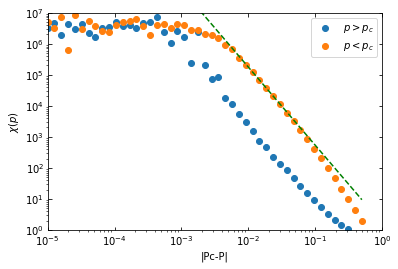

$\gamma$= 2.5180662615876326


In [157]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.scatter(var_gamma_pos- Pc,acs_gamma_pos, label='$p>p_c$')
plt.scatter(abs(Pc-var_gamma_neg),acs_gamma_neg, label='$p<p_c$')
plt.plot(abs(Pc-var_gamma_neg), func(abs(Pc-var_gamma_neg), *popt), '--', color='green')

plt.xscale('log')
# plt.xlim(10**(-5), 1)

plt.yscale('log')
plt.xlim(10**(-5), 1)
plt.ylim(1,10**7)
plt.xlabel('|Pc-P|')
plt.ylabel('$\chi(p)$')
plt.legend()
plt.show()
print('$\gamma$=', gamma)

L=5000

In [151]:
43/18

2.388888888888889

## Cluster Number Density

The following defined function will use the result of Hoshen and Kopelman of the clusters. With the list of the clusters it will calculate the frequency of the clusters by using a dictionairy. And it wil average out in the end.
I see it in a way to reduce 'noise'.

In [158]:
def cluster_number_density(size, p, iterations):
    appearances=collections.defaultdict(int)
    
    for i in range(iterations):
        M=create_world(size,p)
        HK=Hoshen_and_Kopelman(M)
        for curr in HK[4]:
            appearances[curr] += 1
            
    data = list(appearances.items())
    
    an_array = np.array(data)
    an_array[:,1]=an_array[:,1]/(size)**2

    an_array=an_array[np.argsort(an_array[:,0])]
    an_array[:,1]=an_array[:,1]/iterations
    
    return an_array

In [161]:
%%time
size=5000
cnd1_=cluster_number_density(size,0.47,5)
cnd2_=cluster_number_density(size,0.5,5)
cnd3_=cluster_number_density(size,0.53,5)
cnd4_=cluster_number_density(size,0.56,5)

Wall time: 41.1 s


In [162]:
#if a cluster only comes one time after a few iterations
#it only brings the average down a lot and does not contribute well to the average
#this function will skip if a cluster size only appears once during the loop
def skip_ones(cnd, treshold=1/(size)**2):
    result=np.array([])
    for el in (cnd):
        if el[1]>treshold:
            result=np.append(result,[el])
    return result.reshape(int(len(result)/2),2)

In [163]:
cnd1=skip_ones(cnd1_)
cnd2=skip_ones(cnd2_)
cnd3=skip_ones(cnd3_)
cnd4=skip_ones(cnd4_)

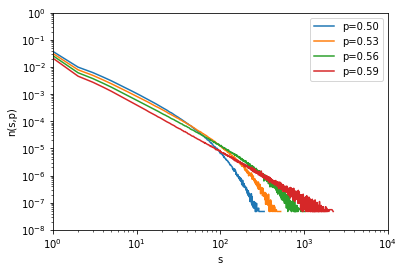

In [164]:
plt.plot(cnd1[:,0],cnd1[:,1],label='p=0.50')
plt.plot(cnd2[:,0],cnd2[:,1],label='p=0.53')
plt.plot(cnd3[:,0],cnd3[:,1],label='p=0.56')
plt.plot(cnd4[:,0],cnd4[:,1],label='p=0.59')
# plt.plot(10,1/(200**2),'o')
plt.yscale('log')
plt.ylim(10**-8, 1)
plt.xlim(1, 10**4)
plt.xscale('log')
plt.xlabel('s')
plt.ylabel('n(s,p)')
plt.legend()
plt.show()

In [165]:
from scipy.stats import binned_statistic

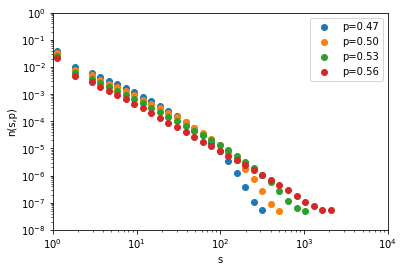

In [167]:
fig, ax = plt.subplots()

binnetjes=50
x=cnd1[:,0]
y=cnd1[:,1]
s, edges, _ = binned_statistic(x,y, statistic='mean', bins=np.logspace(0,5,binnetjes))
ys = np.repeat(s,2)
xs = np.repeat(edges,2)[1:-1]
ax.scatter(edges[:-1]+np.diff(edges)/2, s, label='p=0.47')

x=cnd2[:,0]
y=cnd2[:,1]
s, edges, _ = binned_statistic(x,y, statistic='mean', bins=np.logspace(0,5,binnetjes))
ys = np.repeat(s,2)
xs = np.repeat(edges,2)[1:-1]
ax.scatter(edges[:-1]+np.diff(edges)/2, s,label='p=0.50')

x=cnd3[:,0]
y=cnd3[:,1]
s, edges, _ = binned_statistic(x,y, statistic='mean', bins=np.logspace(0,5,binnetjes))
ys = np.repeat(s,2)
xs = np.repeat(edges,2)[1:-1]
ax.scatter(edges[:-1]+np.diff(edges)/2, s,label='p=0.53')

x=cnd4[:,0]
y=cnd4[:,1]
s, edges, _ = binned_statistic(x,y, statistic='mean', bins=np.logspace(0,5,binnetjes))
ys = np.repeat(s,2)
xs = np.repeat(edges,2)[1:-1]
ax.scatter(edges[:-1]+np.diff(edges)/2, s,label='p=0.56')

plt.ylim(10**-8, 1)
plt.xlim(1, 10**4)
plt.xlabel('s')
plt.ylabel('n(s,p)')
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

## $\tau$

In [154]:
cnd_=cluster_number_density(5000,Pc,10)

In [140]:
cnd=skip_ones(cnd_,10/(5000**3))
;

''

In [141]:
x=cnd[:,0]
y=cnd[:,1]
s, edges, _ = binned_statistic(x,y, statistic='mean', bins=np.logspace(0,5,binnetjes))
xs = np.repeat(s,2)
ys = np.repeat(edges,2)[1:-1]

S=edges[:-1]+np.diff(edges)/2
N=s

In [142]:
import math
def skip_nan(S,N):
    s=np.array([])
    n=np.array([])
    for ind, el in enumerate(N):
        if math.isnan(el)==False:
            n=np.append(n,el)
            s=np.append(s,S[ind])
    return s, n

In [143]:
[s_,n_]=skip_nan(S,N)
xdata_tau=s_[13:]
ydata_tau=n_[13:]

In [144]:
popt, pcov = curve_fit(func, xdata_tau, ydata_tau)
tau=-popt[1]

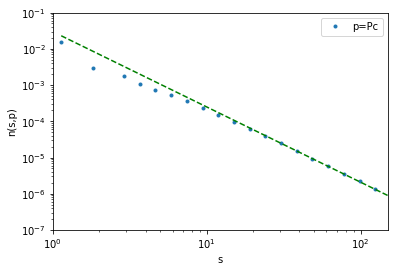

tau = 2.0766205829343143


In [145]:
plt.loglog(s_,n_,'.',label='p=Pc')
plt.loglog(s_, func(s_, *popt), 'g--')
plt.xlim(1,150)
plt.ylim(10**-7,0.1)
plt.xlabel('s')
plt.ylabel('n(s,p)')
plt.legend()
plt.show()
print('tau =', tau)

wiki: tau = 187/91=2.06 (source: https://en.wikipedia.org/wiki/Percolation_critical_exponents#Exponents_for_standard_percolation)

In [147]:
187/91

2.0549450549450547